In [1]:
# Dataset Used https://www.kaggle.com/datasets/tannergi/microcontroller-detection
import torch
import cv2
import numpy as np
import os
import enum
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
import torch.optim
from PIL import Image
import glob as glob
import matplotlib.pyplot as plt
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2

In [2]:
BATCH_SIZE = 1
RESIZE_TO = 512  
NUM_EPOCHS = 25
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
TRAIN_DIR = "../input/microcontroller-detection/Microcontroller Detection/train"
VALID_DIR = "../input/microcontroller-detection/Microcontroller Detection/test"
CLASSES = [
    "background",
    "Arduino_Nano",
    "ESP8266",
    "Raspberry_Pi_3",
    "Heltec_ESP32_Lora",
]
NUM_CLASSES = 5
VISUALIZE_TRANSFORMED_IMAGES = False
OUT_DIR = "../outputs"
SAVE_PLOTS_EPOCH = 2  
SAVE_MODEL_EPOCH = 2  

In [3]:
class Averager:
    def __init__(self) -> None:
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose(
        [
            A.Flip(0.5),
            A.RandomRotate90(0.5),
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            ToTensorV2(p=1.0),
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
    )

def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
    )

In [4]:
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = [x for x in os.listdir(dir_path) if x.endswith(".jpg")]
        self.all_images = sorted(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        annot_filename = image_name[:-4] + ".xml"
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        image_width = image.shape[1]
        image_height = image.shape[0]

        for member in root.findall("object"):
            labels.append(self.classes.index(member.find("name").text))
            xmin = int(member.find("bndbox").find("xmin").text)
            xmax = int(member.find("bndbox").find("xmax").text)
            ymin = int(member.find("bndbox").find("ymin").text)
            ymax = int(member.find("bndbox").find("ymax").text)

            xmin_final = (xmin / image_width) * self.width
            xmax_final = (xmax / image_width) * self.width
            ymin_final = (ymin / image_height) * self.height
            yamx_final = (ymax / image_height) * self.height

            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=labels
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return image_resized, target

    def __len__(self):
        return len(self.all_images)


train_dataset = MicrocontrollerDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
)
valid_dataset = MicrocontrollerDataset(
    VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 142
Number of validation samples: 7



In [5]:
i,t = next(iter(train_loader))
t

({'boxes': tensor([[283.3067, 268.1600, 391.6800, 394.8800]]),
  'labels': tensor([2]),
  'area': tensor([13733.0684]),
  'iscrowd': tensor([0]),
  'image_id': tensor([129])},)

In [6]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

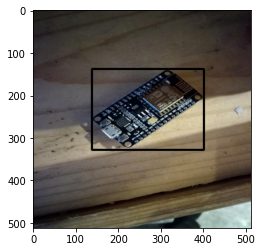

In [7]:
image, target = next(iter(train_loader))
image = image[0].permute(1,2,0).detach().cpu().numpy()
bboxes = target[0]['boxes'].numpy()
for box in bboxes:
    box = box.astype(int)
    cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,0,0),3)
plt.imshow(image,cmap='gray')

In [8]:
plt.style.use("ggplot")


def train(train_data_loader, model):
    print("Training")
    global train_itr
    global train_loss_list
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list


def validate(valid_data_loader, model):
    print("validating")
    global val_itr
    global loss_list

    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)

        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return val_loss_list

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

MODEL_NAME = "model"

if VISUALIZE_TRANSFORMED_IMAGES:

    show_transformed_image(train_loader)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1} of {NUM_EPOCHS}")

    train_loss_hist.reset()
    val_loss_hist.reset()

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch + 1) % SAVE_MODEL_EPOCH == 0:  # save model after every n epochs
        torch.save(model.state_dict(), f"model{epoch+1}.pth")
        print("SAVING MODEL COMPLETE...\n")

    if (epoch + 1) % SAVE_PLOTS_EPOCH == 0:  # save loss plots after n epochs
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"train_loss_{epoch+1}.png")
        figure_2.savefig(f"valid_loss_{epoch+1}.png")
        print("SAVING PLOTS COMPLETE...")

    if (epoch + 1) == NUM_EPOCHS:  # save loss plots and model once at the end
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"train_loss_{epoch+1}.png")
        figure_2.savefig(f"valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"model{epoch+1}.pth")

    plt.close("all")
    # sleep for 5 seconds after each epoch
    time.sleep(5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]


Epoch 1 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #0 train loss: 0.350
Epoch #0 validation loss: 0.215
Took 0.442 minutes for epoch 0

Epoch 2 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #1 train loss: 0.195
Epoch #1 validation loss: 0.131
Took 0.318 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 3 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #2 train loss: 0.134
Epoch #2 validation loss: 0.115
Took 0.319 minutes for epoch 2

Epoch 4 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #3 train loss: 0.108
Epoch #3 validation loss: 0.102
Took 0.325 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 5 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #4 train loss: 0.089
Epoch #4 validation loss: 0.097
Took 0.322 minutes for epoch 4

Epoch 6 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #5 train loss: 0.081
Epoch #5 validation loss: 0.073
Took 0.319 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 7 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #6 train loss: 0.075
Epoch #6 validation loss: 0.063
Took 0.319 minutes for epoch 6

Epoch 8 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #7 train loss: 0.068
Epoch #7 validation loss: 0.069
Took 0.324 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 9 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #8 train loss: 0.064
Epoch #8 validation loss: 0.066
Took 0.322 minutes for epoch 8

Epoch 10 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #9 train loss: 0.061
Epoch #9 validation loss: 0.060
Took 0.320 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 11 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #10 train loss: 0.058
Epoch #10 validation loss: 0.061
Took 0.319 minutes for epoch 10

Epoch 12 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #11 train loss: 0.056
Epoch #11 validation loss: 0.055
Took 0.318 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 13 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #12 train loss: 0.054
Epoch #12 validation loss: 0.052
Took 0.316 minutes for epoch 12

Epoch 14 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #13 train loss: 0.051
Epoch #13 validation loss: 0.059
Took 0.319 minutes for epoch 13
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 15 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #14 train loss: 0.050
Epoch #14 validation loss: 0.051
Took 0.321 minutes for epoch 14

Epoch 16 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #15 train loss: 0.048
Epoch #15 validation loss: 0.048
Took 0.321 minutes for epoch 15
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 17 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #16 train loss: 0.047
Epoch #16 validation loss: 0.057
Took 0.317 minutes for epoch 16

Epoch 18 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #17 train loss: 0.048
Epoch #17 validation loss: 0.050
Took 0.318 minutes for epoch 17
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 19 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #18 train loss: 0.043
Epoch #18 validation loss: 0.051
Took 0.320 minutes for epoch 18

Epoch 20 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #19 train loss: 0.044
Epoch #19 validation loss: 0.060
Took 0.316 minutes for epoch 19
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 21 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #20 train loss: 0.047
Epoch #20 validation loss: 0.045
Took 0.317 minutes for epoch 20

Epoch 22 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #21 train loss: 0.039
Epoch #21 validation loss: 0.052
Took 0.324 minutes for epoch 21
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 23 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #22 train loss: 0.041
Epoch #22 validation loss: 0.052
Took 0.319 minutes for epoch 22

Epoch 24 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #23 train loss: 0.041
Epoch #23 validation loss: 0.052
Took 0.317 minutes for epoch 23
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 25 of 25
Training


  0%|          | 0/142 [00:00<?, ?it/s]

validating


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch #24 train loss: 0.042
Epoch #24 validation loss: 0.056
Took 0.314 minutes for epoch 24


In [9]:
import urllib
f = open('00000001.jpg','wb')
f.write(urllib.request.urlopen('https://nettigo.eu/system/images/2876/original.JPG?1526644243').read())
f.close()

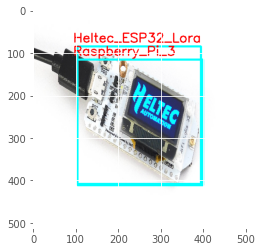

In [10]:
image = cv2.imread("./00000001.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image_resized = cv2.resize(image, (RESIZE_TO,RESIZE_TO))
image_resized /= 255.0
    
m = ToTensorV2(p=1.0)
ld  = m(image =image_resized)
images =  ld['image'].to(DEVICE)
ims = images.unsqueeze(0)
model.eval()
index=0
output= model(ims)
boxes = output[index]['boxes'].detach().cpu().numpy().astype(int) 
labels = output[index]['labels'].detach().cpu().numpy()
for box,label in zip(boxes,labels):
    cv2.rectangle(image_resized,(box[0],box[1]),(box[2],box[3]),(0,255,255),4)
    cv2.putText(image_resized, CLASSES[label], (box[0]-10,box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
               1, (255, 0, 0), 2, cv2.LINE_AA)
plt.imshow(image_resized)

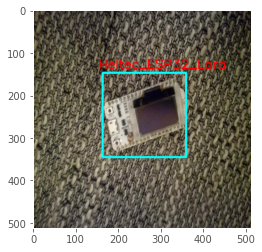

In [11]:
for images,target in train_loader:
    model.eval()
    index = 0
    img = images[index].detach().permute(1,2,0).numpy()
    images = list(image.to(DEVICE) for image in images)
    output = model(images)
    boxes = output[index]['boxes'].detach().cpu().numpy().astype(int) 
    labels = output[index]['labels'].detach().cpu().numpy()
    for box,label in zip(boxes,labels):
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,255),4)
        cv2.putText(img, CLASSES[label], (box[0]-10,box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.grid(None)
    break